# Dynamic Mode Decomposition - Time Series Forecasting

Dynamic mode decomposition (DMD) is a dimensionality reduction technique using singular value decomposition to extract spatial temporal dynamics from periodic data. Energy prices in the CAISO are a prime example of a periodic data set. This notebook will go over how to augment time series data to be able to exploit DMD as a forecasting tool.

In [13]:
import numpy as np
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from scipy import linalg as la

plt.style.use('fivethirtyeight')
plt.rcParams['lines.linewidth'] = 1

In [19]:
path = './../../datasets/all_prices.csv'
df = pd.read_csv(path, header=None)
X = df.to_numpy()

# EDA

California energy prices clearly have a periodic nature which should be able to be exploited from DMD. The graph below gives a base idea of the input-output data for DMD training.

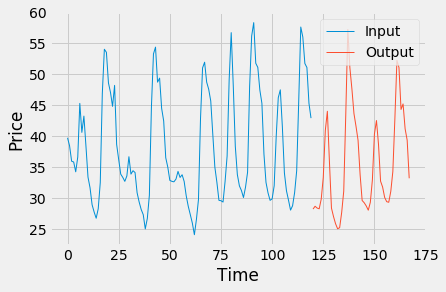

In [15]:
node = 133
start = 23
m = 24*5
n = 48

def plot_prices(X, start, m, n, node):

    end_train = start + m
    end_test = end_train + n + 1
    t_in = np.arange(m)
    t_out = np.arange(n) + max(t_in) + 1
    input_y = X[node][start:end_train]
    output_y = X[node][end_train + 1:end_test]
    
    fig, ax = plt.subplots()
    ax.plot(t_in, input_y, label ='Input')
    ax.plot(t_out, output_y, label='Output')
    ax.set_ylabel('Price')
    ax.set_xlabel('Time')
    ax.legend()
    return fig, ax

fig, ax = plot_prices(X, start, m, n, node)

# Mathematics 

**The following formulation was taken from my thesis written on DMD**

The following decomposition information is taken from Kutz’s book “Dynamic Mode Decomposition” and is consistent with the original formulation from Schmid et. al. It is important to define the basics of DMD that will be used in order to model the system in question. DMD starts with an input matrix $X_t$ where the columns of $X_t$ are the spacial data in question and each column represents a discrete time measurement. Therefore, $X_t$ has m rows where m is the number of spacial points and n columns where n is the number of time measurements. The matrix $X_t$ can then be split into two matrices as shown below. Note that each $\textbf{x}_{i}$ is a column of spacial data in $X_t$.

$$X^f = [\textbf{x}_{1} \cdots \textbf{x}_{n} ]$$   
$$X = [\textbf{x}_{i} \cdots \textbf{x}_{n - 1}]$$   
$$X' = [\textbf{x}_{i} \cdots  \textbf{x}_{n-1}]$$

Once $X_t$ has been split, the overall goal of DMD is to produce a best fit linear operator with the following property. 

$$AX ≈ X'$$

This best fit operator $A$ will be the forecasting operator that allows for the prediction of future measurements. The following decomposition allows for the construction of the $A$ matix. Note that * indicates a conjugate transpose as DMD can be applied to complex systems as well as real systems. Also, note that equation 3 is just a singular value decomposition of $X$. 

$$X=UΣV^*$$
$$A=U^* X' VΣ^{-1}$$

*Important mathematical note: rank truncation of the SVD is performed between Equations 3 and 4. The number of singular values used can range from 1 to the number of time measurements.*

The matrix $A$ is then projected onto the modes given by the matrix U and a standard eigen decomposition is performed on the reduced matrix $\overset{~}{A}$ in Equation 6. This is useful because the matrix $A$ can be greatly reduced in dimensions with some simple truncation of singular values in Equation 4. 

$$\overset{~}{A}=U^* AU$$
$$\overset{~}{A}W=WΛ$$

Lastly, the DMD modes are defined in Equation 7. These modes can then be used to estimate any column of data at a given time, $x(t)$. Equation 8 shows how to obtain this prediction. $Ω$ is a diagonal matrix that contains the natural logarithm of eigen values divided by the difference in time, $Δt$ , given along the diagonal of $Λ$ i.e. $Ω_ii=(〖ln⁡(λ〗_i))/Δt$  . The vector $b$ is given by solving the linear system given in Equation 9 where $x_1$ is the first column of the $X$ matrix.

$$Φ=X' VΣ^{-1} W$$
$$x(X_t,t)=Φ exp⁡(Ωt)b$$
$$Φb=x_1$$

At this point the decomposition of the original data is done, and forecasting can be performed in any fashion desired with a given dataset by using Equation 8. Also, the reconstruction of the original data can be obtained from the DMD composition as shown in Equations 10 and 11. Note the $D$ matrix stands for the dynamics of the system. $D$ is constructed by using Equation 8 at every time step in the training set. Equation 10 shows how one column ($D_{(:,j)}$) would be constructed using Equation 8. Also note the $j$ index on $D$ corresponds with $t_j$ where $t_j$ comes from the $j^{th}$ input timestep in the input time vector. This makes each column of $D$ correspond to the time dynamics at each input time. 

$$D_{(:,j)}= Φ exp⁡(Ωt_j )b$$ 
$$X_{DMD}=ΦD$$


Lastly, the DMD modes are defined in Equation 7. These modes can then be used to estimate any column of data at a given time, $x(t)$. Equation 8 shows how to obtain this prediction. $\Omega$ is a diagonal matrix that contains the natural logarithm of eigen values divided by the difference in time, $\Delta t$ , given along the diagonal of $\Lambda$ i.e. $\Omega_ii=((ln⁡(\lambda)_i))/ \Delta t$  . The vector $b$ is given by solving the linear system given in Equation 9 where $x_1$ is the first column of the $X$ matrix.

$$\Phi=X' V\Sigma^{-1} W$$
$$x(X_t,t)=\Phi exp⁡(\Omega t)b$$
$$\Phi b=x_1$$

At this point the decomposition of the original data is done, and forecasting can be performed in any fashion desired with a given dataset by using Equation 8. Also, the reconstruction of the original data can be obtained from the DMD composition as shown in Equations 10 and 11. Note the $D$ matrix stands for the dynamics of the system. $D$ is constructed by using Equation 8 at every time step in the training set. Equation 10 shows how one column ($D_{(:,j)}$) would be constructed using Equation 8. Also note the $j$ index on $D$ corresponds with $t_j$ where $t_j$ comes from the $j^{th}$ input time step in the input time vector. This makes each column of $D$ correspond to the time dynamics at each input time. 

$$D_{(:,j)}= \Phi exp⁡(\Omega t_j )b$$ 
$$X_{DMD}=\Phi D$$

# Preprocessing - Data Augmenting

One of the most important things that must occur for DMD to work on stagnant time series such as the one shown above in the EDA section is what is called data augmentation. This is a process where the "standing wave" time series is converted into a matrix of "augmented" time series. This augmented data can then be processed by DMD to extract a periodic nature. 

The function below shows a representation of how to augment a time series.

In [16]:
x = np.arange(10)
def augment_matrix(x, n):
    
    '''
    Function to take a vector x and returns an augmented matrix X which 
    has n rows.
    '''
    
    # length of full time series
    num_elements = x.shape[0]
    
    # length of each row in the X matrix
    len_row = num_elements - n + 1
    
    # initalize the matrix
    X = []
    
    # loop over each row
    for row_num in range(n):
        
        # grab the smaller vector
        small_vec = x[row_num:row_num + len_row]
        
        # append the vector
        X.append(small_vec)
        
    return np.array(X)
        
X_aug = augment_matrix(x,3)
print('Original Vector:',x)
print('Augmented Matrix (Level 3):'); print(X_aug)

Original Vector: [0 1 2 3 4 5 6 7 8 9]
Augmented Matrix (Level 3):
[[0 1 2 3 4 5 6 7]
 [1 2 3 4 5 6 7 8]
 [2 3 4 5 6 7 8 9]]


Now the process of augmenting a dataset has beeen established, let's apply this to some of the energy prices to see what this will look like.

Original Vector Shape: (192,)
Augmented Matrix Shape: (96, 97)


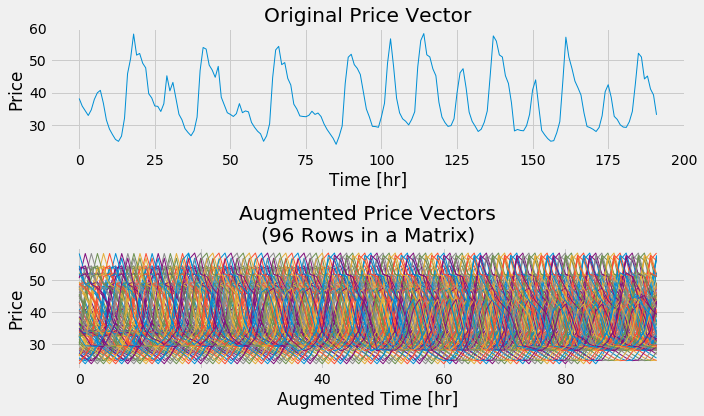

In [31]:
num_rows = 96
len_rows = 96
loc = 133

x = X[loc][0:len_rows+num_rows]
X_aug = augment_matrix(x ,num_rows)

print('Original Vector Shape:', x.shape)
print('Augmented Matrix Shape:', X_aug.shape)

fig, ax = plt.subplots(2,1, figsize = (10,6))
ax[0].plot(x)
ax[0].set_ylabel('Price')
ax[0].set_xlabel('Time [hr]')
ax[0].set_title('Original Price Vector')

ax[1].plot(X_aug)
ax[1].set_ylabel('Price')
ax[1].set_xlabel('Augmented Time [hr]')
ax[1].set_title('Augmented Price Vectors\n(96 Rows in a Matrix)')
fig.tight_layout()
plt.show()

#